## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
  
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 200
model_layers = [512, 256]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/f' + str(i))

print(models, model_names)

inputs = ['a', 'b']
target = ['c']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/f0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.1679 - mean_squared_error: 1.1679 - val_loss: 1.0386 - val_mean_squared_error: 1.0386

Epoch 00001: val_loss improved from inf to 1.03856, saving model to temp/f0
Epoch 2/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0232 - mean_squared_error: 1.0232 - val_loss: 1.0223 - val_mean_squared_error: 1.0223

Epoch 00002: val_loss improved from 1.03856 to 1.02233, saving model to temp/f0
Epoch 3/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0242 - mean_squared_error: 1.0242 - val_loss: 1.0161 - val_mean_squared_error: 1.0161

Epoch 00003: val_loss improved from 1.02233 to 1.01612, saving model to temp/f0
Epoch 4/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0209 - mean_squared_error: 1.0209 - val_loss: 1.0257 - val_mean_squared_error: 1.0257

Epoch 00004: val_loss did not 

20000/20000 [==============================] - 2s 118us/step - loss: 1.1594 - mean_squared_error: 1.1594 - val_loss: 1.0220 - val_mean_squared_error: 1.0220

Epoch 00001: val_loss improved from inf to 1.02197, saving model to temp/f4
Epoch 2/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0258 - mean_squared_error: 1.0258 - val_loss: 1.0208 - val_mean_squared_error: 1.0208

Epoch 00002: val_loss improved from 1.02197 to 1.02083, saving model to temp/f4
Epoch 3/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0160 - mean_squared_error: 1.0160 - val_loss: 1.0179 - val_mean_squared_error: 1.0179

Epoch 00003: val_loss improved from 1.02083 to 1.01795, saving model to temp/f4
Epoch 4/20
20000/20000 [==============================] - 2s 109us/step - loss: 1.0168 - mean_squared_error: 1.0168 - val_loss: 1.0097 - val_mean_squared_error: 1.0097

Epoch 00004: val_loss improved from 1.01795 to 1.00968, saving model to temp/f4
Epoch 5/20
20000/20

20000/20000 [==============================] - 2s 123us/step - loss: 1.0226 - mean_squared_error: 1.0226 - val_loss: 1.0173 - val_mean_squared_error: 1.0173

Epoch 00002: val_loss improved from 1.01942 to 1.01728, saving model to temp/f10
Epoch 3/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0204 - mean_squared_error: 1.0204 - val_loss: 1.0096 - val_mean_squared_error: 1.0096

Epoch 00003: val_loss improved from 1.01728 to 1.00959, saving model to temp/f10
Epoch 4/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0207 - mean_squared_error: 1.0207 - val_loss: 1.0199 - val_mean_squared_error: 1.0199

Epoch 00004: val_loss did not improve from 1.00959
Epoch 5/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0136 - mean_squared_error: 1.0136 - val_loss: 1.0116 - val_mean_squared_error: 1.0116

Epoch 00005: val_loss did not improve from 1.00959
Epoch 00005: early stopping
temp/f11
Train on 20000 samples, validate o


Epoch 00007: val_loss did not improve from 1.01153
Epoch 8/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0120 - mean_squared_error: 1.0120 - val_loss: 1.0073 - val_mean_squared_error: 1.0073

Epoch 00008: val_loss improved from 1.01153 to 1.00733, saving model to temp/f15
Epoch 9/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0108 - mean_squared_error: 1.0108 - val_loss: 1.0076 - val_mean_squared_error: 1.0076

Epoch 00009: val_loss did not improve from 1.00733
Epoch 10/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0098 - mean_squared_error: 1.0098 - val_loss: 1.0119 - val_mean_squared_error: 1.0119

Epoch 00010: val_loss did not improve from 1.00733
Epoch 00010: early stopping
temp/f16
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.1730 - mean_squared_error: 1.1730 - val_loss: 1.0222 - val_mean_squared_error: 1.0222

E

20000/20000 [==============================] - 2s 123us/step - loss: 1.0197 - mean_squared_error: 1.0197 - val_loss: 1.0154 - val_mean_squared_error: 1.0154

Epoch 00002: val_loss improved from 1.02538 to 1.01542, saving model to temp/f20
Epoch 3/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0199 - mean_squared_error: 1.0199 - val_loss: 1.0193 - val_mean_squared_error: 1.0193

Epoch 00003: val_loss did not improve from 1.01542
Epoch 4/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0207 - mean_squared_error: 1.0207 - val_loss: 1.0122 - val_mean_squared_error: 1.0122

Epoch 00004: val_loss improved from 1.01542 to 1.01219, saving model to temp/f20
Epoch 5/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0080 - val_mean_squared_error: 1.0080

Epoch 00005: val_loss improved from 1.01219 to 1.00796, saving model to temp/f20
Epoch 6/20
20000/20000 [=================

20000/20000 [==============================] - 2s 123us/step - loss: 1.0112 - mean_squared_error: 1.0112 - val_loss: 1.0152 - val_mean_squared_error: 1.0152

Epoch 00009: val_loss did not improve from 1.00662
Epoch 00009: early stopping
temp/f25
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.1733 - mean_squared_error: 1.1733 - val_loss: 1.0209 - val_mean_squared_error: 1.0209

Epoch 00001: val_loss improved from inf to 1.02095, saving model to temp/f25
Epoch 2/20
20000/20000 [==============================] - 2s 121us/step - loss: 1.0299 - mean_squared_error: 1.0299 - val_loss: 1.0210 - val_mean_squared_error: 1.0210

Epoch 00002: val_loss did not improve from 1.02095
Epoch 3/20
20000/20000 [==============================] - 2s 121us/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 1.0174 - val_mean_squared_error: 1.0174

Epoch 00003: val_loss improved from 1.02095 to 1.01743, saving model 

20000/20000 [==============================] - 2s 123us/step - loss: 1.0166 - mean_squared_error: 1.0166 - val_loss: 1.0171 - val_mean_squared_error: 1.0171

Epoch 00005: val_loss did not improve from 1.01145
Epoch 6/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0141 - mean_squared_error: 1.0141 - val_loss: 1.0081 - val_mean_squared_error: 1.0081

Epoch 00006: val_loss improved from 1.01145 to 1.00809, saving model to temp/f30
Epoch 7/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 1.0118 - val_mean_squared_error: 1.0118

Epoch 00007: val_loss did not improve from 1.00809
Epoch 8/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0117 - mean_squared_error: 1.0117 - val_loss: 1.0274 - val_mean_squared_error: 1.0274

Epoch 00008: val_loss did not improve from 1.00809
Epoch 00008: early stopping
temp/f31
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
200

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.1519 - mean_squared_error: 1.1519 - val_loss: 1.0206 - val_mean_squared_error: 1.0206

Epoch 00001: val_loss improved from inf to 1.02062, saving model to temp/f35
Epoch 2/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.0197 - mean_squared_error: 1.0197 - val_loss: 1.0248 - val_mean_squared_error: 1.0248

Epoch 00002: val_loss did not improve from 1.02062
Epoch 3/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.0143 - val_mean_squared_error: 1.0143

Epoch 00003: val_loss improved from 1.02062 to 1.01433, saving model to temp/f35
Epoch 4/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.0170 - mean_squared_error: 1.0170 - val_loss: 1.0174 - val_mean_squared_error: 1.0174

Epoch 00004: val_loss did not improve from 1.01433
Epoch 5/20
200

20000/20000 [==============================] - 2s 109us/step - loss: 1.0189 - mean_squared_error: 1.0189 - val_loss: 1.0192 - val_mean_squared_error: 1.0192

Epoch 00004: val_loss did not improve from 1.01145
Epoch 5/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.0121 - mean_squared_error: 1.0121 - val_loss: 1.0096 - val_mean_squared_error: 1.0096

Epoch 00005: val_loss improved from 1.01145 to 1.00958, saving model to temp/f40
Epoch 6/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0160 - mean_squared_error: 1.0160 - val_loss: 1.0103 - val_mean_squared_error: 1.0103

Epoch 00006: val_loss did not improve from 1.00958
Epoch 7/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.0158 - mean_squared_error: 1.0158 - val_loss: 1.0086 - val_mean_squared_error: 1.0086

Epoch 00007: val_loss improved from 1.00958 to 1.00859, saving model to temp/f40
Epoch 8/20
20000/20000 [==============================] - 2s 113us/step

20000/20000 [==============================] - 2s 106us/step - loss: 1.0236 - mean_squared_error: 1.0236 - val_loss: 1.0229 - val_mean_squared_error: 1.0229

Epoch 00002: val_loss improved from 1.02534 to 1.02292, saving model to temp/f45
Epoch 3/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.0197 - mean_squared_error: 1.0197 - val_loss: 1.0120 - val_mean_squared_error: 1.0120

Epoch 00003: val_loss improved from 1.02292 to 1.01200, saving model to temp/f45
Epoch 4/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 1.0334 - val_mean_squared_error: 1.0334

Epoch 00004: val_loss did not improve from 1.01200
Epoch 5/20
20000/20000 [==============================] - 2s 110us/step - loss: 1.0165 - mean_squared_error: 1.0165 - val_loss: 1.0150 - val_mean_squared_error: 1.0150

Epoch 00005: val_loss did not improve from 1.01200
Epoch 00005: early stopping
temp/f46
Train on 20000 samples, validate o

20000/20000 [==============================] - 2s 106us/step - loss: 1.0189 - mean_squared_error: 1.0189 - val_loss: 1.0155 - val_mean_squared_error: 1.0155

Epoch 00004: val_loss improved from 1.01990 to 1.01548, saving model to temp/f49
Epoch 5/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.0099 - mean_squared_error: 1.0099 - val_loss: 1.0126 - val_mean_squared_error: 1.0126

Epoch 00005: val_loss improved from 1.01548 to 1.01264, saving model to temp/f49
Epoch 6/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.0078 - mean_squared_error: 1.0078 - val_loss: 1.0102 - val_mean_squared_error: 1.0102

Epoch 00006: val_loss improved from 1.01264 to 1.01019, saving model to temp/f49
Epoch 7/20
20000/20000 [==============================] - 2s 112us/step - loss: 1.0090 - mean_squared_error: 1.0090 - val_loss: 1.0106 - val_mean_squared_error: 1.0106

Epoch 00007: val_loss did not improve from 1.01019
Epoch 8/20
20000/20000 [=================

20000/20000 [==============================] - 2s 109us/step - loss: 1.0253 - mean_squared_error: 1.0253 - val_loss: 1.0159 - val_mean_squared_error: 1.0159

Epoch 00002: val_loss improved from 1.01914 to 1.01589, saving model to temp/f54
Epoch 3/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0191 - mean_squared_error: 1.0191 - val_loss: 1.0180 - val_mean_squared_error: 1.0180

Epoch 00003: val_loss did not improve from 1.01589
Epoch 4/20
20000/20000 [==============================] - 2s 102us/step - loss: 1.0135 - mean_squared_error: 1.0135 - val_loss: 1.0153 - val_mean_squared_error: 1.0153

Epoch 00004: val_loss improved from 1.01589 to 1.01529, saving model to temp/f54
Epoch 5/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0214 - mean_squared_error: 1.0214 - val_loss: 1.0114 - val_mean_squared_error: 1.0114

Epoch 00005: val_loss improved from 1.01529 to 1.01137, saving model to temp/f54
Epoch 6/20
20000/20000 [=================

20000/20000 [==============================] - 2s 107us/step - loss: 1.0137 - mean_squared_error: 1.0137 - val_loss: 1.0067 - val_mean_squared_error: 1.0067

Epoch 00007: val_loss improved from 1.01042 to 1.00674, saving model to temp/f58
Epoch 8/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0116 - mean_squared_error: 1.0116 - val_loss: 1.0141 - val_mean_squared_error: 1.0141

Epoch 00008: val_loss did not improve from 1.00674
Epoch 9/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0160 - mean_squared_error: 1.0160 - val_loss: 1.0080 - val_mean_squared_error: 1.0080

Epoch 00009: val_loss did not improve from 1.00674
Epoch 00009: early stopping
temp/f59
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 121us/step - loss: 1.1567 - mean_squared_error: 1.1567 - val_loss: 1.0187 - val_mean_squared_error: 1.0187

Epoch 00001: val_loss improved from inf to 1.01870, saving model 

20000/20000 [==============================] - 2s 107us/step - loss: 1.0200 - mean_squared_error: 1.0200 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00004: val_loss improved from 1.02036 to 1.01725, saving model to temp/f63
Epoch 5/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 1.0273 - val_mean_squared_error: 1.0273

Epoch 00005: val_loss did not improve from 1.01725
Epoch 6/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0157 - mean_squared_error: 1.0157 - val_loss: 1.0219 - val_mean_squared_error: 1.0219

Epoch 00006: val_loss did not improve from 1.01725
Epoch 00006: early stopping
temp/f64
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.1674 - mean_squared_error: 1.1674 - val_loss: 1.0280 - val_mean_squared_error: 1.0280

Epoch 00001: val_loss improved from inf to 1.02804, saving model 

20000/20000 [==============================] - 2s 103us/step - loss: 1.0157 - mean_squared_error: 1.0157 - val_loss: 1.0117 - val_mean_squared_error: 1.0117

Epoch 00005: val_loss improved from 1.01373 to 1.01167, saving model to temp/f69
Epoch 6/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0181 - mean_squared_error: 1.0181 - val_loss: 1.0084 - val_mean_squared_error: 1.0084

Epoch 00006: val_loss improved from 1.01167 to 1.00839, saving model to temp/f69
Epoch 7/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0141 - mean_squared_error: 1.0141 - val_loss: 1.0169 - val_mean_squared_error: 1.0169

Epoch 00007: val_loss did not improve from 1.00839
Epoch 8/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0131 - mean_squared_error: 1.0131 - val_loss: 1.0028 - val_mean_squared_error: 1.0028

Epoch 00008: val_loss improved from 1.00839 to 1.00279, saving model to temp/f69
Epoch 9/20
20000/20000 [=================

20000/20000 [==============================] - 2s 113us/step - loss: 1.1689 - mean_squared_error: 1.1689 - val_loss: 1.0198 - val_mean_squared_error: 1.0198

Epoch 00001: val_loss improved from inf to 1.01975, saving model to temp/f74
Epoch 2/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0236 - mean_squared_error: 1.0236 - val_loss: 1.0248 - val_mean_squared_error: 1.0248

Epoch 00002: val_loss did not improve from 1.01975
Epoch 3/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0221 - mean_squared_error: 1.0221 - val_loss: 1.0193 - val_mean_squared_error: 1.0193

Epoch 00003: val_loss improved from 1.01975 to 1.01931, saving model to temp/f74
Epoch 4/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0147 - val_mean_squared_error: 1.0147

Epoch 00004: val_loss improved from 1.01931 to 1.01473, saving model to temp/f74
Epoch 5/20
20000/20000 [=====================

20000/20000 [==============================] - 2s 106us/step - loss: 1.0167 - mean_squared_error: 1.0167 - val_loss: 1.0103 - val_mean_squared_error: 1.0103

Epoch 00005: val_loss improved from 1.01794 to 1.01028, saving model to temp/f78
Epoch 6/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0232 - val_mean_squared_error: 1.0232

Epoch 00006: val_loss did not improve from 1.01028
Epoch 7/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0191 - mean_squared_error: 1.0191 - val_loss: 1.0171 - val_mean_squared_error: 1.0171

Epoch 00007: val_loss did not improve from 1.01028
Epoch 00007: early stopping
temp/f79
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.1519 - mean_squared_error: 1.1519 - val_loss: 1.0267 - val_mean_squared_error: 1.0267

Epoch 00001: val_loss improved from inf to 1.02675, saving model 

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.1628 - mean_squared_error: 1.1628 - val_loss: 1.0249 - val_mean_squared_error: 1.0249

Epoch 00001: val_loss improved from inf to 1.02491, saving model to temp/f85
Epoch 2/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0261 - mean_squared_error: 1.0261 - val_loss: 1.0289 - val_mean_squared_error: 1.0289

Epoch 00002: val_loss did not improve from 1.02491
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0182 - mean_squared_error: 1.0182 - val_loss: 1.0108 - val_mean_squared_error: 1.0108

Epoch 00003: val_loss improved from 1.02491 to 1.01081, saving model to temp/f85
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0209 - mean_squared_error: 1.0209 - val_loss: 1.0160 - val_mean_squared_error: 1.0160

Epoch 00004: val_loss did not improve from 1.01081
Epoch 5/20
200


Epoch 00003: val_loss improved from 1.02256 to 1.01860, saving model to temp/f90
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0144 - mean_squared_error: 1.0144 - val_loss: 1.0216 - val_mean_squared_error: 1.0216

Epoch 00004: val_loss did not improve from 1.01860
Epoch 5/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0200 - mean_squared_error: 1.0200 - val_loss: 1.0106 - val_mean_squared_error: 1.0106

Epoch 00005: val_loss improved from 1.01860 to 1.01061, saving model to temp/f90
Epoch 6/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 1.0074 - val_mean_squared_error: 1.0074

Epoch 00006: val_loss improved from 1.01061 to 1.00743, saving model to temp/f90
Epoch 7/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0098 - mean_squared_error: 1.0098 - val_loss: 1.0061 - val_mean_squared_error: 1.0061

Epoch 00007: val_loss improve


Epoch 00006: val_loss did not improve from 1.00912
Epoch 7/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0140 - mean_squared_error: 1.0140 - val_loss: 1.0090 - val_mean_squared_error: 1.0090

Epoch 00007: val_loss improved from 1.00912 to 1.00900, saving model to temp/f95
Epoch 8/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.0173 - mean_squared_error: 1.0173 - val_loss: 1.0253 - val_mean_squared_error: 1.0253

Epoch 00008: val_loss did not improve from 1.00900
Epoch 9/20
20000/20000 [==============================] - 2s 108us/step - loss: 1.0081 - mean_squared_error: 1.0081 - val_loss: 1.0075 - val_mean_squared_error: 1.0075

Epoch 00009: val_loss improved from 1.00900 to 1.00752, saving model to temp/f95
Epoch 10/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0151 - mean_squared_error: 1.0151 - val_loss: 1.0073 - val_mean_squared_error: 1.0073

Epoch 00010: val_loss improved from 1.00752 to 1.00726, sa

20000/20000 [==============================] - 2s 105us/step - loss: 1.0250 - mean_squared_error: 1.0250 - val_loss: 1.0301 - val_mean_squared_error: 1.0301

Epoch 00003: val_loss did not improve from 1.01829
Epoch 4/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0221 - mean_squared_error: 1.0221 - val_loss: 1.0152 - val_mean_squared_error: 1.0152

Epoch 00004: val_loss improved from 1.01829 to 1.01517, saving model to temp/f99
Epoch 5/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0190 - mean_squared_error: 1.0190 - val_loss: 1.0082 - val_mean_squared_error: 1.0082

Epoch 00005: val_loss improved from 1.01517 to 1.00815, saving model to temp/f99
Epoch 6/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 1.0087 - val_mean_squared_error: 1.0087

Epoch 00006: val_loss did not improve from 1.00815
Epoch 7/20
20000/20000 [==============================] - 2s 104us/step

20000/20000 [==============================] - 2s 107us/step - loss: 1.0189 - mean_squared_error: 1.0189 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00005: val_loss did not improve from 1.01287
Epoch 6/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0121 - mean_squared_error: 1.0121 - val_loss: 1.0194 - val_mean_squared_error: 1.0194

Epoch 00006: val_loss did not improve from 1.01287
Epoch 00006: early stopping
temp/f105
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.1514 - mean_squared_error: 1.1514 - val_loss: 1.0237 - val_mean_squared_error: 1.0237

Epoch 00001: val_loss improved from inf to 1.02366, saving model to temp/f105
Epoch 2/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0239 - mean_squared_error: 1.0239 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00002: val_loss improved from 1.02366 to 1.01721, saving mode


Epoch 00001: val_loss improved from inf to 1.04001, saving model to temp/f109
Epoch 2/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0247 - mean_squared_error: 1.0247 - val_loss: 1.0153 - val_mean_squared_error: 1.0153

Epoch 00002: val_loss improved from 1.04001 to 1.01535, saving model to temp/f109
Epoch 3/20
20000/20000 [==============================] - 2s 103us/step - loss: 1.0226 - mean_squared_error: 1.0226 - val_loss: 1.0194 - val_mean_squared_error: 1.0194

Epoch 00003: val_loss did not improve from 1.01535
Epoch 4/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0234 - mean_squared_error: 1.0234 - val_loss: 1.0134 - val_mean_squared_error: 1.0134

Epoch 00004: val_loss improved from 1.01535 to 1.01338, saving model to temp/f109
Epoch 5/20
20000/20000 [==============================] - 2s 105us/step - loss: 1.0168 - mean_squared_error: 1.0168 - val_loss: 1.0130 - val_mean_squared_error: 1.0130

Epoch 00005: val_loss improved

20000/20000 [==============================] - 2s 107us/step - loss: 1.0156 - mean_squared_error: 1.0156 - val_loss: 1.0088 - val_mean_squared_error: 1.0088

Epoch 00005: val_loss improved from 1.01628 to 1.00879, saving model to temp/f113
Epoch 6/20
20000/20000 [==============================] - 2s 104us/step - loss: 1.0147 - mean_squared_error: 1.0147 - val_loss: 1.0398 - val_mean_squared_error: 1.0398

Epoch 00006: val_loss did not improve from 1.00879
Epoch 7/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0190 - mean_squared_error: 1.0190 - val_loss: 1.0128 - val_mean_squared_error: 1.0128

Epoch 00007: val_loss did not improve from 1.00879
Epoch 00007: early stopping
temp/f114
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 121us/step - loss: 1.1648 - mean_squared_error: 1.1648 - val_loss: 1.0255 - val_mean_squared_error: 1.0255

Epoch 00001: val_loss improved from inf to 1.02549, saving mode

20000/20000 [==============================] - 2s 106us/step - loss: 1.0256 - mean_squared_error: 1.0256 - val_loss: 1.0199 - val_mean_squared_error: 1.0199

Epoch 00002: val_loss improved from 1.03643 to 1.01995, saving model to temp/f117
Epoch 3/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0191 - mean_squared_error: 1.0191 - val_loss: 1.0163 - val_mean_squared_error: 1.0163

Epoch 00003: val_loss improved from 1.01995 to 1.01635, saving model to temp/f117
Epoch 4/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.0141 - val_mean_squared_error: 1.0141

Epoch 00004: val_loss improved from 1.01635 to 1.01413, saving model to temp/f117
Epoch 5/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.0161 - val_mean_squared_error: 1.0161

Epoch 00005: val_loss did not improve from 1.01413
Epoch 6/20
20000/20000 [==============

20000/20000 [==============================] - 2s 109us/step - loss: 1.0140 - mean_squared_error: 1.0140 - val_loss: 1.0076 - val_mean_squared_error: 1.0076

Epoch 00008: val_loss did not improve from 1.00705
Epoch 9/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0124 - mean_squared_error: 1.0124 - val_loss: 1.0106 - val_mean_squared_error: 1.0106

Epoch 00009: val_loss did not improve from 1.00705
Epoch 00009: early stopping
temp/f122
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.1633 - mean_squared_error: 1.1633 - val_loss: 1.0333 - val_mean_squared_error: 1.0333

Epoch 00001: val_loss improved from inf to 1.03330, saving model to temp/f122
Epoch 2/20
20000/20000 [==============================] - 2s 99us/step - loss: 1.0258 - mean_squared_error: 1.0258 - val_loss: 1.0272 - val_mean_squared_error: 1.0272

Epoch 00002: val_loss improved from 1.03330 to 1.02724, saving model

20000/20000 [==============================] - 2s 106us/step - loss: 1.0303 - mean_squared_error: 1.0303 - val_loss: 1.0170 - val_mean_squared_error: 1.0170

Epoch 00002: val_loss improved from 1.02736 to 1.01695, saving model to temp/f126
Epoch 3/20
20000/20000 [==============================] - 2s 89us/step - loss: 1.0200 - mean_squared_error: 1.0200 - val_loss: 1.0178 - val_mean_squared_error: 1.0178

Epoch 00003: val_loss did not improve from 1.01695
Epoch 4/20
20000/20000 [==============================] - 2s 100us/step - loss: 1.0237 - mean_squared_error: 1.0237 - val_loss: 1.0120 - val_mean_squared_error: 1.0120

Epoch 00004: val_loss improved from 1.01695 to 1.01205, saving model to temp/f126
Epoch 5/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0185 - mean_squared_error: 1.0185 - val_loss: 1.0112 - val_mean_squared_error: 1.0112

Epoch 00005: val_loss improved from 1.01205 to 1.01116, saving model to temp/f126
Epoch 6/20
20000/20000 [===============

20000/20000 [==============================] - 2s 121us/step - loss: 1.0209 - mean_squared_error: 1.0209 - val_loss: 1.0131 - val_mean_squared_error: 1.0131

Epoch 00002: val_loss improved from 1.02372 to 1.01313, saving model to temp/f131
Epoch 3/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0224 - mean_squared_error: 1.0224 - val_loss: 1.0165 - val_mean_squared_error: 1.0165

Epoch 00003: val_loss did not improve from 1.01313
Epoch 4/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 1.0061 - val_mean_squared_error: 1.0061

Epoch 00004: val_loss improved from 1.01313 to 1.00612, saving model to temp/f131
Epoch 5/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0184 - mean_squared_error: 1.0184 - val_loss: 1.0133 - val_mean_squared_error: 1.0133

Epoch 00005: val_loss did not improve from 1.00612
Epoch 6/20
20000/20000 [==============================] - 2s 119us/st

20000/20000 [==============================] - 2s 125us/step - loss: 1.0181 - mean_squared_error: 1.0181 - val_loss: 1.0104 - val_mean_squared_error: 1.0104

Epoch 00004: val_loss improved from 1.01813 to 1.01044, saving model to temp/f135
Epoch 5/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0163 - mean_squared_error: 1.0163 - val_loss: 1.0095 - val_mean_squared_error: 1.0095

Epoch 00005: val_loss improved from 1.01044 to 1.00951, saving model to temp/f135
Epoch 6/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0139 - mean_squared_error: 1.0139 - val_loss: 1.0161 - val_mean_squared_error: 1.0161

Epoch 00006: val_loss did not improve from 1.00951
Epoch 7/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0142 - mean_squared_error: 1.0142 - val_loss: 1.0194 - val_mean_squared_error: 1.0194

Epoch 00007: val_loss did not improve from 1.00951
Epoch 00007: early stopping
temp/f136
Train on 20000 samples, validat

20000/20000 [==============================] - 2s 124us/step - loss: 1.0127 - mean_squared_error: 1.0127 - val_loss: 1.0077 - val_mean_squared_error: 1.0077

Epoch 00007: val_loss improved from 1.01011 to 1.00768, saving model to temp/f139
Epoch 8/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0091 - mean_squared_error: 1.0091 - val_loss: 1.0090 - val_mean_squared_error: 1.0090

Epoch 00008: val_loss did not improve from 1.00768
Epoch 9/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0130 - mean_squared_error: 1.0130 - val_loss: 1.0083 - val_mean_squared_error: 1.0083

Epoch 00009: val_loss did not improve from 1.00768
Epoch 00009: early stopping
temp/f140
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.1661 - mean_squared_error: 1.1661 - val_loss: 1.0186 - val_mean_squared_error: 1.0186

Epoch 00001: val_loss improved from inf to 1.01864, saving mode


Epoch 00002: val_loss improved from 1.02987 to 1.01978, saving model to temp/f144
Epoch 3/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0218 - mean_squared_error: 1.0218 - val_loss: 1.0205 - val_mean_squared_error: 1.0205

Epoch 00003: val_loss did not improve from 1.01978
Epoch 4/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0202 - mean_squared_error: 1.0202 - val_loss: 1.0211 - val_mean_squared_error: 1.0211

Epoch 00004: val_loss did not improve from 1.01978
Epoch 00004: early stopping
temp/f145
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.1446 - mean_squared_error: 1.1446 - val_loss: 1.0246 - val_mean_squared_error: 1.0246

Epoch 00001: val_loss improved from inf to 1.02459, saving model to temp/f145
Epoch 2/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0227 - mean_squared_error: 1.0227 - val_loss: 1.0139 - val_m

20000/20000 [==============================] - 2s 121us/step - loss: 1.0225 - mean_squared_error: 1.0225 - val_loss: 1.0259 - val_mean_squared_error: 1.0259

Epoch 00003: val_loss did not improve from 1.01642
Epoch 4/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0220 - mean_squared_error: 1.0220 - val_loss: 1.0146 - val_mean_squared_error: 1.0146

Epoch 00004: val_loss improved from 1.01642 to 1.01460, saving model to temp/f149
Epoch 5/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0159 - mean_squared_error: 1.0159 - val_loss: 1.0162 - val_mean_squared_error: 1.0162

Epoch 00005: val_loss did not improve from 1.01460
Epoch 6/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 1.0158 - val_mean_squared_error: 1.0158

Epoch 00006: val_loss did not improve from 1.01460
Epoch 00006: early stopping
temp/f150
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
2

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.1516 - mean_squared_error: 1.1516 - val_loss: 1.0264 - val_mean_squared_error: 1.0264

Epoch 00001: val_loss improved from inf to 1.02639, saving model to temp/f154
Epoch 2/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0232 - mean_squared_error: 1.0232 - val_loss: 1.0551 - val_mean_squared_error: 1.0551

Epoch 00002: val_loss did not improve from 1.02639
Epoch 3/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0198 - mean_squared_error: 1.0198 - val_loss: 1.0195 - val_mean_squared_error: 1.0195

Epoch 00003: val_loss improved from 1.02639 to 1.01954, saving model to temp/f154
Epoch 4/20
20000/20000 [==============================] - 2s 121us/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.0102 - val_mean_squared_error: 1.0102

Epoch 00004: val_loss improved from 1.01954 to 1.01016, saving 

20000/20000 [==============================] - 2s 123us/step - loss: 1.0209 - mean_squared_error: 1.0209 - val_loss: 1.0097 - val_mean_squared_error: 1.0097

Epoch 00004: val_loss improved from 1.01695 to 1.00974, saving model to temp/f159
Epoch 5/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0158 - mean_squared_error: 1.0158 - val_loss: 1.0096 - val_mean_squared_error: 1.0096

Epoch 00005: val_loss improved from 1.00974 to 1.00959, saving model to temp/f159
Epoch 6/20
20000/20000 [==============================] - 2s 107us/step - loss: 1.0178 - mean_squared_error: 1.0178 - val_loss: 1.0258 - val_mean_squared_error: 1.0258

Epoch 00006: val_loss did not improve from 1.00959
Epoch 7/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0120 - mean_squared_error: 1.0120 - val_loss: 1.0184 - val_mean_squared_error: 1.0184

Epoch 00007: val_loss did not improve from 1.00959
Epoch 00007: early stopping
temp/f160
Train on 20000 samples, validat

20000/20000 [==============================] - 2s 123us/step - loss: 1.0251 - mean_squared_error: 1.0251 - val_loss: 1.0255 - val_mean_squared_error: 1.0255

Epoch 00003: val_loss did not improve from 1.02148
Epoch 4/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0219 - mean_squared_error: 1.0219 - val_loss: 1.0195 - val_mean_squared_error: 1.0195

Epoch 00004: val_loss improved from 1.02148 to 1.01953, saving model to temp/f165
Epoch 5/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0152 - mean_squared_error: 1.0152 - val_loss: 1.0140 - val_mean_squared_error: 1.0140

Epoch 00005: val_loss improved from 1.01953 to 1.01401, saving model to temp/f165
Epoch 6/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 1.0101 - val_mean_squared_error: 1.0101

Epoch 00006: val_loss improved from 1.01401 to 1.01011, saving model to temp/f165
Epoch 7/20
20000/20000 [==============

20000/20000 [==============================] - 2s 116us/step - loss: 1.0230 - mean_squared_error: 1.0230 - val_loss: 1.0198 - val_mean_squared_error: 1.0198

Epoch 00004: val_loss did not improve from 1.01766
Epoch 00004: early stopping
temp/f171
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.1611 - mean_squared_error: 1.1611 - val_loss: 1.0272 - val_mean_squared_error: 1.0272

Epoch 00001: val_loss improved from inf to 1.02715, saving model to temp/f171
Epoch 2/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0205 - mean_squared_error: 1.0205 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00002: val_loss improved from 1.02715 to 1.01716, saving model to temp/f171
Epoch 3/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0181 - mean_squared_error: 1.0181 - val_loss: 1.0202 - val_mean_squared_error: 1.0202

Epoch 00003: val_loss did not improv

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.1814 - mean_squared_error: 1.1814 - val_loss: 1.0331 - val_mean_squared_error: 1.0331

Epoch 00001: val_loss improved from inf to 1.03313, saving model to temp/f176
Epoch 2/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0278 - mean_squared_error: 1.0278 - val_loss: 1.0300 - val_mean_squared_error: 1.0300

Epoch 00002: val_loss improved from 1.03313 to 1.03001, saving model to temp/f176
Epoch 3/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0233 - mean_squared_error: 1.0233 - val_loss: 1.0167 - val_mean_squared_error: 1.0167

Epoch 00003: val_loss improved from 1.03001 to 1.01666, saving model to temp/f176
Epoch 4/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0195 - mean_squared_error: 1.0195 - val_loss: 1.0138 - val_mean_squared_error: 1.0138

Epoch 00004: val_loss improved f

20000/20000 [==============================] - 2s 117us/step - loss: 1.0179 - mean_squared_error: 1.0179 - val_loss: 1.0180 - val_mean_squared_error: 1.0180

Epoch 00005: val_loss did not improve from 1.01393
Epoch 6/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0213 - mean_squared_error: 1.0213 - val_loss: 1.0207 - val_mean_squared_error: 1.0207

Epoch 00006: val_loss did not improve from 1.01393
Epoch 00006: early stopping
temp/f182
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.1601 - mean_squared_error: 1.1601 - val_loss: 1.0330 - val_mean_squared_error: 1.0330

Epoch 00001: val_loss improved from inf to 1.03302, saving model to temp/f182
Epoch 2/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0247 - mean_squared_error: 1.0247 - val_loss: 1.0201 - val_mean_squared_error: 1.0201

Epoch 00002: val_loss improved from 1.03302 to 1.02009, saving mode

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.1490 - mean_squared_error: 1.1490 - val_loss: 1.0222 - val_mean_squared_error: 1.0222

Epoch 00001: val_loss improved from inf to 1.02215, saving model to temp/f187
Epoch 2/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 1.0324 - val_mean_squared_error: 1.0324

Epoch 00002: val_loss did not improve from 1.02215
Epoch 3/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0241 - mean_squared_error: 1.0241 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00003: val_loss improved from 1.02215 to 1.01723, saving model to temp/f187
Epoch 4/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 1.0126 - val_mean_squared_error: 1.0126

Epoch 00004: val_loss improved from 1.01723 to 1.01263, saving 

20000/20000 [==============================] - 2s 89us/step - loss: 1.0269 - mean_squared_error: 1.0269 - val_loss: 1.0237 - val_mean_squared_error: 1.0237

Epoch 00002: val_loss improved from 1.02677 to 1.02375, saving model to temp/f191
Epoch 3/20
20000/20000 [==============================] - 2s 92us/step - loss: 1.0180 - mean_squared_error: 1.0180 - val_loss: 1.0225 - val_mean_squared_error: 1.0225

Epoch 00003: val_loss improved from 1.02375 to 1.02251, saving model to temp/f191
Epoch 4/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0162 - mean_squared_error: 1.0162 - val_loss: 1.0160 - val_mean_squared_error: 1.0160

Epoch 00004: val_loss improved from 1.02251 to 1.01605, saving model to temp/f191
Epoch 5/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0151 - mean_squared_error: 1.0151 - val_loss: 1.0044 - val_mean_squared_error: 1.0044

Epoch 00005: val_loss improved from 1.01605 to 1.00438, saving model to temp/f191
Epoch 6/2

20000/20000 [==============================] - 2s 91us/step - loss: 1.0149 - mean_squared_error: 1.0149 - val_loss: 1.0133 - val_mean_squared_error: 1.0133

Epoch 00005: val_loss did not improve from 1.01071
Epoch 6/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0174 - mean_squared_error: 1.0174 - val_loss: 1.0151 - val_mean_squared_error: 1.0151

Epoch 00006: val_loss did not improve from 1.01071
Epoch 00006: early stopping
temp/f196
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.1591 - mean_squared_error: 1.1591 - val_loss: 1.0249 - val_mean_squared_error: 1.0249

Epoch 00001: val_loss improved from inf to 1.02493, saving model to temp/f196
Epoch 2/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0222 - mean_squared_error: 1.0222 - val_loss: 1.0172 - val_mean_squared_error: 1.0172

Epoch 00002: val_loss improved from 1.02493 to 1.01717, saving model

20000/20000 [==============================] - 2s 118us/step - loss: 1.0133 - mean_squared_error: 1.0133 - val_loss: 1.0082 - val_mean_squared_error: 1.0082

Epoch 00009: val_loss improved from 1.00839 to 1.00823, saving model to temp/f199
Epoch 10/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0110 - mean_squared_error: 1.0110 - val_loss: 1.0134 - val_mean_squared_error: 1.0134

Epoch 00010: val_loss did not improve from 1.00823
Epoch 11/20
20000/20000 [==============================] - 2s 88us/step - loss: 1.0076 - mean_squared_error: 1.0076 - val_loss: 1.0032 - val_mean_squared_error: 1.0032

Epoch 00011: val_loss improved from 1.00823 to 1.00321, saving model to temp/f199
Epoch 12/20
20000/20000 [==============================] - 2s 106us/step - loss: 1.0112 - mean_squared_error: 1.0112 - val_loss: 1.0205 - val_mean_squared_error: 1.0205

Epoch 00012: val_loss did not improve from 1.00321
Epoch 13/20
20000/20000 [==============================] - 2s 117us

In [4]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 0.5]
variances = [1, 1.5]



import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 200
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = get_shap(model, x_test2, nshap)
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/f0
0.5389019644164152
[0.9145106781848173, 1.1632932506480131]
temp/f1
0.5621465322654936
[0.914515310033912, 1.2097777544970751]
temp/f2
0.5334273069753113
[0.9033044170629023, 1.1635501968877202]
temp/f3
0.5435605361426943
[0.8963107546605267, 1.190810317624862]
temp/f4
0.5475939133682264
[0.9040473301087072, 1.1911404966277455]
temp/f5
0.5619723826933206
[0.9223194272259232, 1.201625338160718]
temp/f6
0.5435735500970941
[0.8964533453164971, 1.190693754877691]
temp/f7
0.5717164438795297
[0.9268668636945057, 1.2165660240645537]
temp/f8
0.5607876532189279
[0.9235741342547199, 1.1980011721831358]
temp/f9
0.5674332381743465
[0.9059715260204375, 1.2288949503282556]
temp/f10
0.5396514690701294
[0.9172820656762849, 1.1620208724639738]
temp/f11
0.5672545899575998
[0.9075034855947288, 1.2270056943204708]
temp/f12
0.5433131271714081
[0.8970685796772332, 1.189557674665583]
temp/f13
0.5652792757509364
[0.9409207385408148, 1.1896378129610579]
temp/f14
0.5308291613999376
[0.89475

0.5570849281687961
[0.9060719912504004, 1.2080978650871916]
temp/f120
0.568271250285046
[0.9391377305232989, 1.1974047700467931]
temp/f121
0.5304894248607074
[0.8838882230830398, 1.177090626638375]
temp/f122
0.5408633930746884
[0.8875717035330688, 1.194155082616308]
temp/f123
0.5498519224230349
[0.9090075701220549, 1.1906962747240148]
temp/f124
0.5619635304973577
[0.9179979202373064, 1.2059291407574089]
temp/f125
0.5572481442285481
[0.9268332591700493, 1.1876630292870467]
temp/f126
0.5616352408172207
[0.9208404404328983, 1.2024300412015432]
temp/f127
0.5362343120279391
[0.8874092775981742, 1.185059346457704]
temp/f128
0.5428340952161368
[0.9229691088578091, 1.1626990815744644]
temp/f129
0.545558242078639
[0.881024755185186, 1.210091728972092]
temp/f130
0.5306300959287763
[0.9055017882680972, 1.1557584035894553]
temp/f131
0.5477792512553397
[0.9363850269329272, 1.159173475577752]
temp/f132
0.5363189602292913
[0.8967296248080094, 1.175908295650573]
temp/f133
0.5312512877806485
[0.8855749

1.0603489208118986
[1.2237185812893823, 1.8969792603344147]
temp/f39
1.0593945172768626
[1.2016098741400942, 1.9171791604136308]
temp/f40
1.0604234667054129
[1.1723454513044917, 1.948501482106334]
temp/f41
1.050231815221843
[1.21612806852617, 1.8843355619175162]
temp/f42
1.0612708327379936
[1.2360728117922863, 1.886468853683701]
temp/f43
1.053954240476127
[1.2209265327981644, 1.8869819481540895]
temp/f44
1.0071758885169757
[1.1614956978796867, 1.8528560791542648]
temp/f45
1.032341916836903
[1.2233354168558122, 1.8413484168179937]
temp/f46
1.0449222342912838
[1.2183826259058221, 1.8714618426767455]
temp/f47
1.0459529882079448
[1.1998359075828968, 1.8920700688329928]
temp/f48
1.0198750346843735
[1.1719937407586674, 1.8677563286100796]
temp/f49
1.0165071961583747
[1.1590313513175157, 1.8739830409992337]
temp/f50
1.0384839011527986
[1.2346156501477814, 1.842352152157816]
temp/f51
1.0797492703850584
[1.2354817276604386, 1.9240168131096782]
temp/f52
1.056690896023234
[1.237614395900048, 1.87

1.0246023539483162
[1.2260029044817642, 1.823201803414868]
temp/f159
1.041364625473446
[1.2080451905475393, 1.8746840603993526]
temp/f160
1.0346712667192062
[1.1792972507279582, 1.8900452827104541]
temp/f161
0.9991276944798319
[1.1576091935366777, 1.840646195422986]
temp/f162
1.0248753784573281
[1.177330667563621, 1.8724200893510352]
temp/f163
1.025696663611995
[1.205384129729208, 1.8460091974947819]
temp/f164
1.0079300649880785
[1.173561412346981, 1.8422987176291759]
temp/f165
1.005352462511959
[1.1992906764827647, 1.811414248541153]
temp/f166
1.0633932665862367
[1.2221496270916994, 1.904636906080774]
temp/f167
1.0739869539967732
[1.2112288244919474, 1.936745083501599]
temp/f168
1.0430771982127922
[1.2168469196928948, 1.8693074767326894]
temp/f169
1.0363793840719149
[1.1867301800284453, 1.8860285881153842]
temp/f170
1.0281480611284688
[1.190549138918575, 1.8657469833383624]
temp/f171
1.064267085062923
[1.2045782434492256, 1.9239559266766202]
temp/f172
1.0047680688795086
[1.16509798105

0.4181046397307008
[0.7313665194643295, 1.104842759997072]
temp/f78
0.3852864845303473
[0.7355813634530388, 1.0349916056076558]
temp/f79
0.4054254421195196
[0.7414405467959816, 1.0694103374430575]
temp/f80
0.4323202613934929
[0.7424680928350925, 1.1221724299518931]
temp/f81
0.40479909705994066
[0.7196267630692742, 1.089971431050607]
temp/f82
0.4138558296885575
[0.7482248422378391, 1.0794868171392757]
temp/f83
0.40232582621186663
[0.7261024977765891, 1.0785491546471442]
temp/f84
0.3891530244182829
[0.712936091168387, 1.0653699576681788]
temp/f85
0.4456757398975594
[0.7736118486384379, 1.1177396311566807]
temp/f86
0.4275780962615815
[0.7679312714963232, 1.0872249210268397]
temp/f87
0.4205534033012073
[0.7431483364039341, 1.0979584701984804]
temp/f88
0.41892833046149824
[0.7534034112683428, 1.0844532496546537]
temp/f89
0.40982256672334283
[0.7137800423182208, 1.1058650911284649]
temp/f90
0.4257722740268589
[0.7361681389452189, 1.1153764091084988]
temp/f91
0.4112909438538783
[0.75060273575

0.441741692525222
[0.7613742949044703, 1.1221090901459736]
temp/f196
0.4110993723362154
[0.7267140962337406, 1.0954846484386902]
temp/f197
0.42590802269637384
[0.7515308381788095, 1.1002852072139382]
temp/f198
0.44582948021751456
[0.7587313263980993, 1.1329276340369299]
temp/f199
0.4147335592741149
[0.7402577317110669, 1.0892093868371628]
<<<<<<<< 0.5 1.5
temp/f0
0.9739019275312764
[1.1636708669220808, 1.7841329881404717]
temp/f1
0.9987185131740287
[1.1555628408883352, 1.8418741854597223]
temp/f2
0.9643064962975596
[1.1493534876991058, 1.7792595048960131]
temp/f3
0.9945027011349379
[1.1455962975106269, 1.8434091047592487]
temp/f4
0.9846114799724205
[1.1469187417785425, 1.8223042181662985]
temp/f5
1.0013188092022172
[1.1738064991294492, 1.8288311192749847]
temp/f6
0.9805958446628317
[1.1418965377478485, 1.8192951515778146]
temp/f7
1.025365716351726
[1.1792878364489476, 1.8714435962545042]
temp/f8
0.9936737641973812
[1.1687808552979282, 1.818566673096834]
temp/f9
1.0184849265681861
[1.15

0.9795197097993853
[1.1694655272373546, 1.7895738923614157]
temp/f116
0.9766054977864868
[1.1743369834981636, 1.7788740120748099]
temp/f117
1.017779182536984
[1.1867332134070494, 1.8488251516669185]
temp/f118
0.9656144871082822
[1.1344642679390677, 1.7967647062774967]
temp/f119
0.9873131693479861
[1.1336990285189041, 1.8409273101770678]
temp/f120
1.016013844103501
[1.1888256980859353, 1.8432019901210668]
temp/f121
0.9631738306347597
[1.1186218893300761, 1.807725771939443]
temp/f122
1.0006723333431802
[1.141321464317772, 1.8600232023685883]
temp/f123
0.9868097794220315
[1.1541456042914628, 1.8194739545526002]
temp/f124
1.0146275651474261
[1.1746816301580871, 1.8545735001367651]
temp/f125
0.9924903904674408
[1.185095832477471, 1.7998849484574106]
temp/f126
0.9977536172025151
[1.1575671925800028, 1.8379400418250271]
temp/f127
0.9592827284128542
[1.1164950612687192, 1.8020703955569892]
temp/f128
0.9830342979031951
[1.1682257065692414, 1.7978428892371485]
temp/f129
0.9903877923093006
[1.121

# USING BIC

In [5]:
#the number of times to sample
times = 1


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
full_conx = get_pairs(['a', 'b', 'c'])
forced_conx = set({('a','b'), ('a', 'c'), ('b', 'c')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8710.277034568626
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8791.238213151739
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8717.121951812105
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8711.635839315286
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8755.348512315819
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8831.419035905901
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8706.369718894002
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8830.443720415218
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8769.904544575926
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8836.757425752874
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8721.868399933071
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8809.088579325595
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8728.317625853604
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 

['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8719.418416819542
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8703.10053329106
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8795.322831953135
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8670.783569918287
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8777.885118794897
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8804.042525041572
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8685.01111824159
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8715.565503726388
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8755.597601104526
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8790.608389779998
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8777.3810521763
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8802.899501754044
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8703.930597165581
['a --> b', 'a --> c', 'b --> c']
-9173.112705213785 -8680.982525985

In [44]:
#the number of times to sample
times = 1


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
        structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
        completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
        penaltyDiscount = 200)

    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)

def get_bic2(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, 
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
              penalty = 0
              )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
full_conx = get_pairs(['a', 'b', 'c'])
forced_conx = set({('a','b'), ('a', 'c'), ('b', 'c')})
forced_conx = set({})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )


for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        bic_pred2 =  get_bic2(test_df, prior)
        print(tetrad.getEdges())
        print(bic_pred, bic_pred2, bic_pred / bic_pred2)
        violation_mean[idx][t] = bic_pred2
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --- b', 'a --- c', 'b --- c']
-9239.510616993352 6936.330726005187 -1.3320458585334245
['a --- b', 'a --- c', 'b --- c']
-9324.51609726656 6784.143739765889 -1.3744573309392079
['a --- b', 'a --- c', 'b --- c']
-9209.990622228112 6959.075328912896 -1.3234503417376917
['a --- b', 'a --- c', 'b --- c']
-9252.086567139602 6589.599081192228 -1.4040439263667102
['a --- b', 'a --- c', 'b --- c']
-9294.985693829893 6662.4542065889755 -1.3951293931052342
['a --- b', 'a --- c', 'b --- c']
-9343.88403247673 6729.630546786785 -1.3884690946278142
['a --- b', 'a --- c', 'b --- c']
-9274.514248660384 6517.515960649138 -1.4230136611336586
['a --- b', 'a --- c', 'b --- c']
-9373.555620034864 6296.893700136814 -1.4885999456892853
['a --- b', 'a --- c', 'b --- c']
-9307.672467805332 6092.7651874528065 -1.5276598032980453
['a --- b', 'a --- c', 'b --- c']
-9359.074596736591 6746.538495951794 -1.387240968439212
['a --- b', 'a --- c', 'b --- c']
-9244.443695279939 6607.223021565626 -1.399142

['a --- b', 'a --- c', 'b --- c']
-9257.19845789225 6863.848276810652 -1.34868926068303
['a --- b', 'a --- c', 'b --- c']
-9325.570063734516 6436.662460086769 -1.4488207392513797
['a --- b', 'a --- c', 'b --- c']
-9305.551334609623 6141.1460718934995 -1.5152792696462343
['a --- b', 'a --- c', 'b --- c']
-9308.706198242464 6206.411115819344 -1.4998533008095079
['a --- b', 'a --- c', 'b --- c']
-9259.766241566336 6957.548573115019 -1.3308949473019018
['a --- b', 'a --- c', 'b --- c']
-9313.7141750185 6896.728334946719 -1.350453972186285
['a --- b', 'a --- c', 'b --- c']
-9262.300217922726 6758.324194627817 -1.3705025019790138
['a --- b', 'a --- c', 'b --- c']
-9372.283831412275 6702.651127660679 -1.3982950407092627
['a --- b', 'a --- c', 'b --- c']
-9343.097384732206 6904.708618069904 -1.3531486846933611
['a --- b', 'a --- c', 'b --- c']
-9185.174403221768 6465.78652248 -1.420581142183879
['a --- b', 'a --- c', 'b --- c']
-9287.35743144132 6453.684435330102 -1.4390783318438278
['a --- b'

['a --- b', 'a --- c', 'b --- c']
-9311.346673708684 6474.9464626304525 -1.4380577086541564
['a --- b', 'a --- c', 'b --- c']
-9276.527788960564 6966.831346690191 -1.3315275377475106
['a --- b', 'a --- c', 'b --- c']
-9292.058619091964 6460.865439085041 -1.4382064921023745
['a --- b', 'a --- c', 'b --- c']
-9223.471580279798 6052.569991842479 -1.5238934192766034
['a --- b', 'a --- c', 'b --- c']
-9252.768265463194 6833.705484845663 -1.3539899086933163
['a --- b', 'a --- c', 'b --- c']
-9268.3462182777 7037.8590152492725 -1.3169269515339144
['a --- b', 'a --- c', 'b --- c']
-9312.984555658319 6725.485742692027 -1.384730398957115
['a --- b', 'a --- c', 'b --- c']
-9248.278523964054 6666.418580471401 -1.38729340384595
['a --- b', 'a --- c', 'b --- c']
-9379.174591121018 6942.642085657339 -1.3509517666908484
['a --- b', 'a --- c', 'b --- c']
-9264.619823343932 6710.42898640479 -1.3806300375302216
['a --- b', 'a --- c', 'b --- c']
-9294.890777147846 6642.310260710496 -1.3993460727252474
['a

In [45]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))

    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


temp/f0
Area under surface (rectangular approx) =  7.424379405347262
Violations =  0.0
Average_violations =  6936.330726005187
MSE =  1.047491752947208
0.1595857583831346
temp/f1
Area under surface (rectangular approx) =  7.327546223415439
Violations =  0.0
Average_violations =  6784.143739765889
MSE =  1.0340632062526798
0.16644268821239322
temp/f2
Area under surface (rectangular approx) =  7.471337291126748
Violations =  0.0
Average_violations =  6959.075328912896
MSE =  1.0256533996797492
0.15822212358446308
temp/f3
Area under surface (rectangular approx) =  7.318995626540395
Violations =  0.0
Average_violations =  6589.599081192228
MSE =  1.0533667645371738
0.16278568200559063
temp/f4
Area under surface (rectangular approx) =  7.40012186032943
Violations =  0.0
Average_violations =  6662.4542065889755
MSE =  1.0591327487878688
0.16507698883830094
temp/f5
Area under surface (rectangular approx) =  7.377541728204784
Violations =  0.0
Average_violations =  6729.630546786785
MSE =  1.0

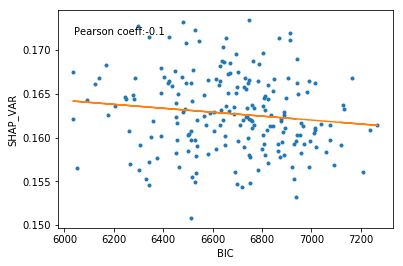

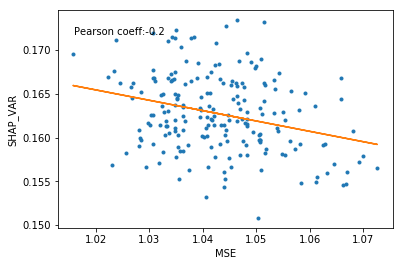

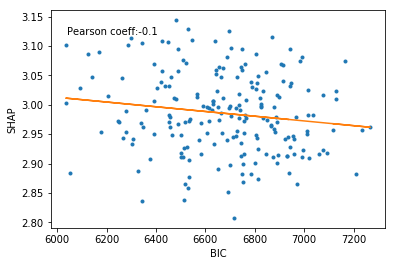

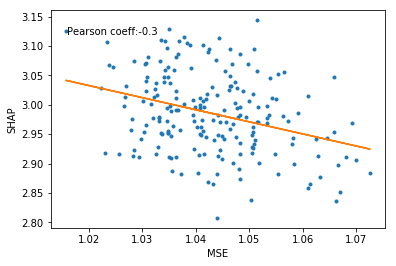

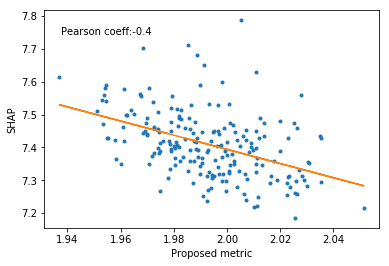

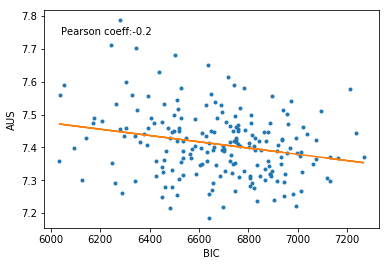

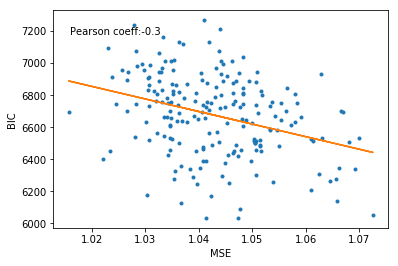

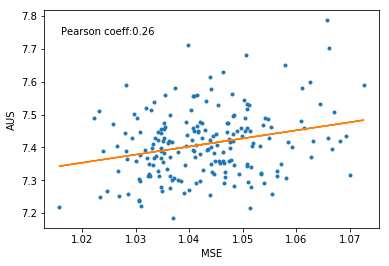

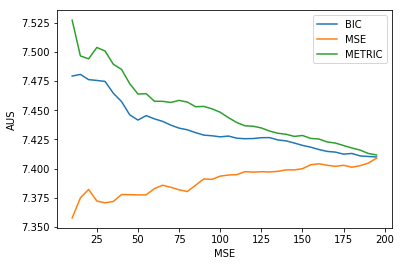

-0.4431019480510043

In [46]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (SHAP/np.max(SHAP)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [47]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + norm(np.array(MSE))
n_low = 30

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  0.16290749070042948
SHAP VAR Best by MSE =  0.16363649208471778
SHAP VAR Best by MET =  0.1655828407883969
SHAP VAR Random =  0.16324172148758379
SHAP Best by BIC =  2.996254319239635
SHAP Best by MSE =  3.007954838411785
SHAP Best by MET =  3.0365643572803998
SHAP Random =  2.990940747465363
AUS Best by BIC =  7.474756046806317
AUS Best by MSE =  7.370754963830701
AUS Best by MET =  7.399144082060601
AUS Random =  7.395594365027405


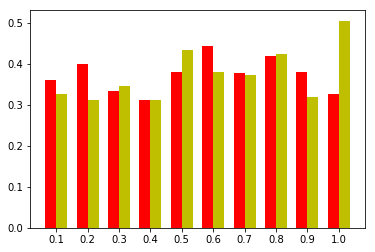

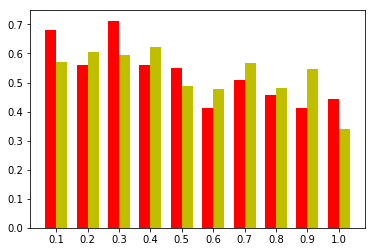

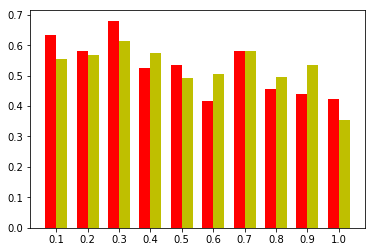

In [48]:
def plot_comparison(x1, x2, y,  bins = 10):
    sorted_y_by_x1 = [y for _,y in sorted(zip(x1,y))]
    sorted_y_by_x2 = [y for _,y in sorted(zip(x2,y))]
    total_len = len(sorted_y_by_x1)
    X = []
    Y1 = []
    Y2 = []
    for i in range(1, bins + 1):
        X.append(i / bins)
        Y1.append(np.mean(sorted_y_by_x1[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
        Y2.append(np.mean(sorted_y_by_x2[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
       
    fig, ax = plt.subplots()

    ind = np.arange(bins)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, Y1, width, color='r',)

    p2 = ax.bar(ind + width, Y2, width,
                color='y' )

    #ax.set_title('Scores by group and gender')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(X)

    #ax.legend((p1[0], p2[0]), ('Men', 'Women'))
    #ax.yaxis.set_units(inch)
    ax.autoscale_view()

    plt.show()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
plot_comparison(METRIC, MSE, normalize(AUS))
plot_comparison(METRIC, MSE, normalize(SHAP))
plot_comparison(METRIC, MSE, normalize(SHAP_VAR))
#plot_comparison(MSE, normalize(AUS))

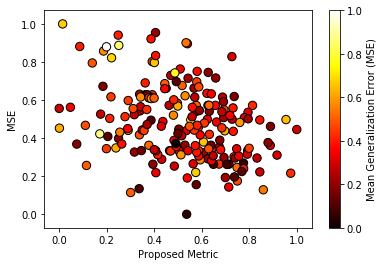

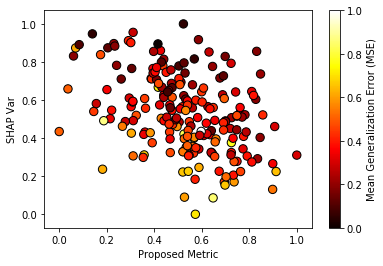

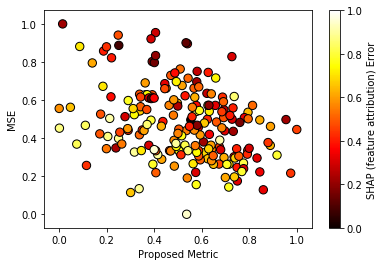

In [49]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', zlab= 'Mean Generalization Error (MSE)', file = 'heat.pdf', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=70, edgecolor='black', cmap = 'hot')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #plt.colorbar(cax)
    cbar = plt.colorbar(cax)
    cbar.set_label(zlab)
    plt.show()
    fig.savefig(file, bbox = 'tight')
    
heat_plot(normalize(VIO), normalize(MSE), normalize(AUS), xlab = 'Proposed Metric', ylab = 'MSE', file = 'METRICvsMSE_Generalization.pdf')

heat_plot(normalize(METRIC), normalize(SHAP), normalize(AUS), xlab = 'Proposed Metric', ylab = 'SHAP Var', )
heat_plot(normalize(VIO), normalize(MSE), normalize(SHAP), xlab = 'Proposed Metric', ylab = 'MSE', zlab = 'SHAP (feature attribution) Error' ,file = 'METRICvsMSE_SHAP.pdf')